# Import Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import plotly
import sklearn
from sklearn import preprocessing

# **Import Data**

In [ ]:
raw_data = pd.read_csv("/content/drive/MyDrive/Data/advertising/advertising_missingdata.csv")
raw_data.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,NaN,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,3/27/2016 0:53,0
1,80.23,31,NaN,193.77,Monitored national standardization,West Jodi,1,Nauru,4/4/2016 1:39,0
2,69.47,26,NaN,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,3/13/2016 20:35,0
3,74.15,29,NaN,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,1/10/2016 2:31,0
4,68.37,35,NaN,225.58,Robust logistical utilization,South Manuel,0,Iceland,6/3/2016 3:36,0


In [ ]:
raw_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Daily Time Spent on Site,1000.0,65.00020,15.853615,32.60,51.3600,68.215,78.5475,91.43
Age,1000.0,36.00900,8.785562,19.00,29.0000,35.000,42.0000,61.00
Area Income,750.0,54993.56688,13196.195985,13996.50,47191.5025,56770.830,65609.2000,79484.80
Daily Internet Usage,1000.0,180.00010,43.902339,104.78,138.8300,183.130,218.7925,269.96
Male,1000.0,0.48100,0.499889,0.00,0.0000,0.000,1.0000,1.00
Clicked on Ad,1000.0,0.50000,0.500250,0.00,0.0000,0.500,1.0000,1.00


In [ ]:
df = raw_data.copy()

In [ ]:
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,NaN,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,3/27/2016 0:53,0
1,80.23,31,NaN,193.77,Monitored national standardization,West Jodi,1,Nauru,4/4/2016 1:39,0
2,69.47,26,NaN,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,3/13/2016 20:35,0
3,74.15,29,NaN,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,1/10/2016 2:31,0
4,68.37,35,NaN,225.58,Robust logistical utilization,South Manuel,0,Iceland,6/3/2016 3:36,0


**The goal of this project is to use the advertisement dataset to build a classification model to predict whether someone click on the ad or not**

- First we will do some quick exploration of the data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               750 non-null    float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 78.2+ KB


- Missing 250 values for Area Income Feature.
- lets explore the data and see what may be the best method for imputation

# **Data Exploration**

In [ ]:
# histogram of Daily Time Spent on Site by gender
import plotly.express as px
fig = px.histogram(df, x="Daily Time Spent on Site", color="Male", opacity=0.65, width=1200)
fig.show()

In [ ]:
fig2 = px.histogram(df, x="Daily Internet Usage", color="Male", opacity=0.65, width=1200)
fig2.show()

**In this data, the Income distributions by gender are similar.  It does appear that replace missing `Area Income` values with group center statistics is much more representative to the sample** 
- We will explore other options after further exploration.

In [ ]:
fig3 = px.histogram(df, x="Area Income", color="Male", opacity=0.70, width=1200)
fig3.show()

**Based on the Plot below, it appears `Daily time spent on the site` and `Daily internet` usage are important in determining whether a person Click on Ad or not.**
- There is clear linear seperation between Clicking on an Ad or not
- A simple model will likely be suitable for the classification task

In [ ]:
import plotly.express as px
df["Clicked on Ad"] = df["Clicked on Ad"].astype(str)
df["Male"] = df["Male"].astype(str)
fig4 = px.scatter(df, x="Daily Internet Usage", y="Daily Time Spent on Site", color="Clicked on Ad", facet_col="Male",opacity=0.75)
fig4.show()

**Many variables appear to have clear linear seperation**
- As aforementioned, this task should not require a sophisticated model to perform well.

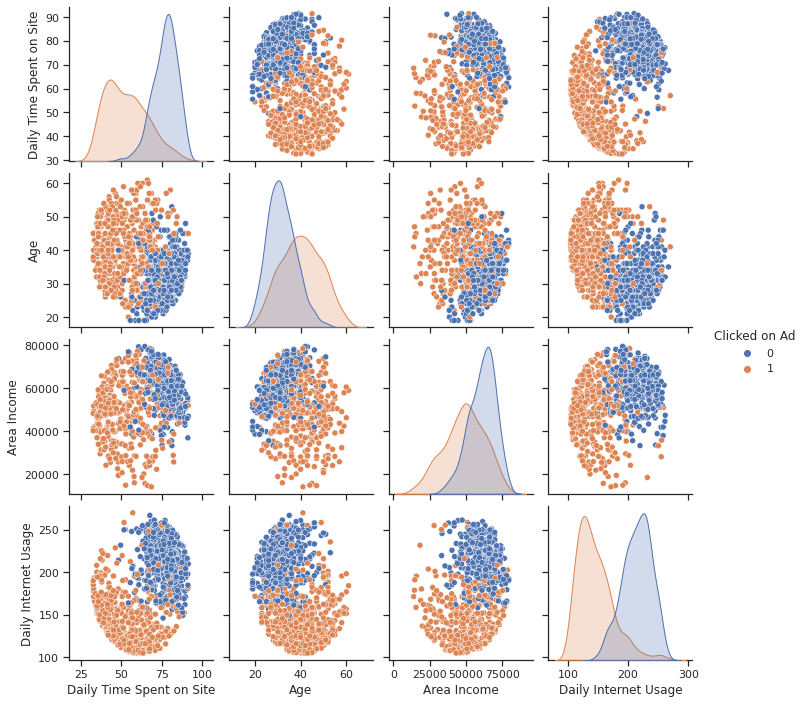

In [ ]:
sns.set_theme(style="ticks")

sns.pairplot(df, hue="Clicked on Ad")

**Lets explore the target distribution to see which model evaluation measures will be best:**

- The target variable, `Clicked on Ad` classes are balanced.
  - Accuracy will be a suitable performance metric for our model.

In [ ]:
fig = px.histogram(df, x="Clicked on Ad", opacity = 0.65, width=600)
fig.update_layout(bargap=0.2)
fig.show()

# **Data Cleaning**

## **Missing Values: Area Income**

- I will impute missing values in `Area Income` with means from Age Group

In [ ]:
df['Age_bracket'] = pd.qcut(df['Age'],5).astype(str)
pd.qcut(df['Age'],5)

0        (32.0, 37.0]
1        (28.0, 32.0]
2      (18.999, 28.0]
3        (28.0, 32.0]
4        (32.0, 37.0]
            ...      
995      (28.0, 32.0]
996      (44.0, 61.0]
997      (44.0, 61.0]
998    (18.999, 28.0]
999    (18.999, 28.0]
Name: Age, Length: 1000, dtype: category
Categories (5, interval[float64]): [(18.999, 28.0] < (28.0, 32.0] < (32.0, 37.0] < (37.0, 44.0] <
                                    (44.0, 61.0]]

In [ ]:
df.groupby(['Age_bracket']).mean()['Area Income']

Age_bracket
(18.999, 28.0]    55438.686407
(28.0, 32.0]      57245.751418
(32.0, 37.0]      58767.211925
(37.0, 44.0]      54864.449870
(44.0, 61.0]      47801.025672
Name: Area Income, dtype: float64

In [ ]:
df['Age_bracket'] = df['Age_bracket'].replace('(18.999, 28.0]', 1).astype(str)
df['Age_bracket'] = df['Age_bracket'].replace('(28.0, 32.0]', 2).astype(str)
df['Age_bracket'] = df['Age_bracket'].replace('(32.0, 37.0]', 3).astype(str)
df['Age_bracket'] = df['Age_bracket'].replace('(37.0, 44.0]', 4).astype(str)
df['Age_bracket'] = df['Age_bracket'].replace('(44.0, 61.0]', 5).astype(str)
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad,Age_bracket
0,68.95,35,NaN,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,3/27/2016 0:53,0,3
1,80.23,31,NaN,193.77,Monitored national standardization,West Jodi,1,Nauru,4/4/2016 1:39,0,2
2,69.47,26,NaN,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,3/13/2016 20:35,0,1
3,74.15,29,NaN,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,1/10/2016 2:31,0,2
4,68.37,35,NaN,225.58,Robust logistical utilization,South Manuel,0,Iceland,6/3/2016 3:36,0,3


In [ ]:
Age_bracket = df.groupby('Age_bracket').median()['Area Income']

for i in range(0,5):
  print('Median Income of age group {}s: {}'.format(i, Age_bracket[i]))
print('Median age of all passengers: {}'.format(df['Area Income'].median()))

# Filling the missing values in Area Income with the medians of Age groups
df['Area Income'] = df.groupby('Age_bracket')['Area Income'].apply(lambda x: x.fillna(x.mean()))

Median Income of age group 0s: 56694.12
Median Income of age group 1s: 59022.235
Median Income of age group 2s: 61467.33
Median Income of age group 3s: 57184.59
Median Income of age group 4s: 48087.18
Median age of all passengers: 56770.83


In [ ]:
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad,Age_bracket
0,68.95,35,58767.211925,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,3/27/2016 0:53,0,3
1,80.23,31,57245.751418,193.77,Monitored national standardization,West Jodi,1,Nauru,4/4/2016 1:39,0,2
2,69.47,26,55438.686407,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,3/13/2016 20:35,0,1
3,74.15,29,57245.751418,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,1/10/2016 2:31,0,2
4,68.37,35,58767.211925,225.58,Robust logistical utilization,South Manuel,0,Iceland,6/3/2016 3:36,0,3


In [ ]:
# Missing values have been imputed
df[df['Area Income'].isnull()]

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad,Age_bracket


## **Timestamp Data**
- I will extract some additional features from the Timestamp feature to make it more useful for our model
- From the Timestamp I will create:
  - Hour of Day
  - Month of Year
  - Day of Week
  - Day of Month

In [ ]:
df['Time of Day'] = pd.to_datetime(df['Timestamp']).dt.hour
df['Day of Month'] = pd.to_datetime(df['Timestamp']).dt.day
df['Day Name'] = pd.to_datetime(df['Timestamp']).dt.day_name()
df['Month of Year'] = pd.to_datetime(df['Timestamp']).dt.month_name()
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad,Age_bracket,Time of Day,Day of Month,Day Name,Month of Year
0,68.95,35,58767.211925,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,3/27/2016 0:53,0,3,0,27,Sunday,March
1,80.23,31,57245.751418,193.77,Monitored national standardization,West Jodi,1,Nauru,4/4/2016 1:39,0,2,1,4,Monday,April
2,69.47,26,55438.686407,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,3/13/2016 20:35,0,1,20,13,Sunday,March
3,74.15,29,57245.751418,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,1/10/2016 2:31,0,2,2,10,Sunday,January
4,68.37,35,58767.211925,225.58,Robust logistical utilization,South Manuel,0,Iceland,6/3/2016 3:36,0,3,3,3,Friday,June


In [ ]:
df['Clicked on Ad'] = df['Clicked on Ad'].astype(int)

In [ ]:
# df_short = df[['Month of Year', 'Day Name', 'Clicked on Ad']]
# df_short = df_short.sort_values(by = ['Month of Year'])

In [ ]:
# df_short2 = df[['Day Name', 'Time of Day', 'Clicked on Ad']]
# df_short2= df_short2.sort_values(by = ['Day Name', 'Time of Day'])

In [ ]:
# data_heat2= df_short2.groupby(['Day Name', 'Time of Day'], as_index=False)['Clicked on Ad'].sum() #['Clicked on Ad'].sum())
# data_heat2 = data_heat2.sort_values(by = ['Day Name', 'Time of Day'])
# data_heat2

In [ ]:
# sns.set_theme()

# # convert to long-form
# long_form2 = data_heat2.pivot("Time of Day", "Day Name", "Clicked on Ad")

# # Draw a heatmap with the numeric values in each cell
# f, ax = plt.subplots(figsize=(9, 6))
# sns.heatmap(long_form2, annot=True, fmt="d", linewidths=.5, ax=ax)

In [ ]:
# data_heat= df_short.groupby(['Month of Year', 'Day Name'], as_index=False) #['Clicked on Ad'].sum())
# data_heat = data_heat.aggregate(np.sum)
# data_heat = data_heat.sort_values(by = ['Month of Year', 'Day Name'])
# data_heat.head()

In [ ]:
# sns.set_theme()

# # convert to long-form
# long_form = data_heat.pivot("Day Name", "Month of Year", "Clicked on Ad")

# # Draw a heatmap with the numeric values in each cell
# f, ax = plt.subplots(figsize=(9, 6))
# sns.heatmap(long_form, annot=True, fmt="d", linewidths=.5, ax=ax)

# **Preprocessing & Model Pipeline**

In [ ]:
# Load packages to handle the Pipeline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [ ]:
# List of all features 
features = ['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Ad Topic Line', 'City', 'Male', 'Country',
       'Timestamp', 'Age_bracket', 'Time of Day',
       'Day of Month', 'Day Name', 'Month of Year', 'Clicked on Ad']
df =df.reindex(columns=features)
data = df.copy()

In [ ]:
# Dropping columns I will not be using 
df.drop(columns=['Age_bracket', 'Timestamp', 'Ad Topic Line', 'City'], inplace=True)
target = df['Clicked on Ad']
df.drop(columns='Clicked on Ad', inplace=True)

# Changing data types back to string
df['Time of Day'] = df['Time of Day'].astype(str)
df['Day of Month'] = df['Day of Month'].astype(str)

## **Split data into training and validation sets**

In [ ]:
# Splitting data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df, target, test_size = 0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0)

In [ ]:
print("Training set shape: ", X_train.shape[0])
print("Validation set shape: ", X_val.shape[0])
print("Testing set shape: ", X_test.shape[0])

Training set shape:  640
Validation set shape:  200
Testing set shape:  160


In [ ]:
print(
    "Using %d samples for training, %d for validation and %d for testing"
    % (len(X_train), len(X_val), len(X_test))
)

Using 640 samples for training, 200 for validation and 160 for testing


## **Logistic Regression - Model Pipeline**

In [ ]:
# List of all numeric features
numeric_features=  ['Daily Time Spent on Site', 'Age','Area Income', 'Daily Internet Usage']

# Numeric feature pipeline
numeric_transformer = Pipeline(steps=[
    # We have already dealt with missing values early (imputer is not necessary here)
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# List of all categorical features
categorical_features = ['Male', 'Country', 'Time of Day', 'Day of Month', 'Day Name', 'Month of Year']
# Categorical feature transformer
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine each transformer
preprocessor = ColumnTransformer(
    transformers=[
                  ('num', numeric_transformer, numeric_features),
                  ('cat', categorical_transformer, categorical_features)])

# Add classifier to preprocessing pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

# Train model
clf.fit(X_train, y_train)
print("Model Score: %.3f" % clf.score(X_val, y_val))

Model Score: 0.945


## **Random Forest Classifier**

In [ ]:
numeric_features=  ['Daily Time Spent on Site', 'Age','Area Income', 'Daily Internet Usage']

# Numeric feature pipeline
numeric_transformer = Pipeline(steps=[
    # We have already dealt with missing values early (imputer is not necessary here)
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# List of all categorical features
categorical_features = ['Male', 'Country', 'Time of Day', 'Day of Month', 'Day Name', 'Month of Year']
# Categorical feature transformer
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine each transformer
preprocessor = ColumnTransformer(
    transformers=[
                  ('num', numeric_transformer, numeric_features),
                  ('cat', categorical_transformer, categorical_features)])

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Add classifier to preprocessing pipeline
clf_rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

# Train model
clf_rf.fit(X_train, y_train)
print("Model Score: %.3f" % clf_rf.score(X_val, y_val))

Model Score: 0.960


- **Another way to construct Pipeline by specifying data types to handle**

In [ ]:
from sklearn.compose import make_column_selector as selector
from sklearn.linear_model import LogisticRegressionCV 

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selector(dtype_exclude="object")),
    ('cat', categorical_transformer, selector(dtype_include="category"))])

clf2 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])


clf2.fit(X_train, y_train)
print("model score: %.3f" % clf2.score(X_val, y_val))

model score: 0.965


## Evaluation Metrics

In [ ]:
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test)
target_names = ['0', '1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        76
           1       1.00      0.88      0.94        84

    accuracy                           0.94       160
   macro avg       0.94      0.94      0.94       160
weighted avg       0.94      0.94      0.94       160



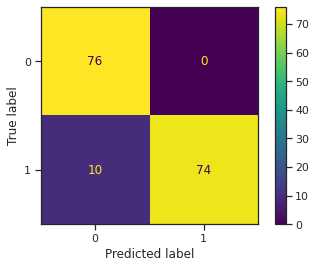

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)
disp.plot()

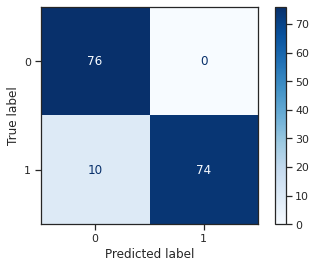

In [ ]:
from sklearn.metrics import plot_confusion_matrix
np.set_printoptions(precision=2)

class_names = clf.classes_

plot_confusion_matrix(clf, X_test, y_test,
                        display_labels=class_names,
                        cmap=plt.cm.Blues)

## ROC Curve

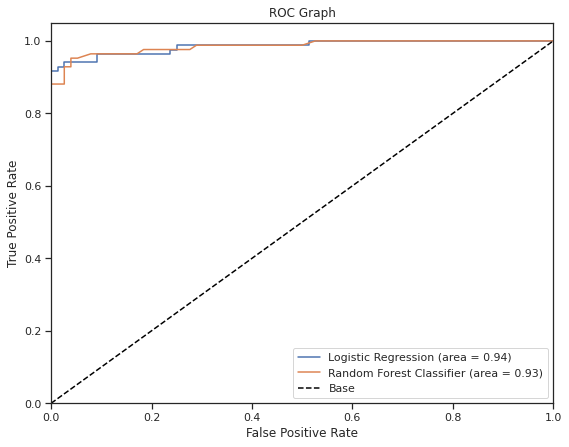

In [ ]:
# Create ROC Graph
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, clf_rf.predict_proba(X_test)[:,1])
lr_auc = roc_auc_score(y_test, clf.predict(X_test))
rf_roc_auc = roc_auc_score(y_test, clf_rf.predict(X_test))


plt.figure(figsize=(9,7))

# Plot Logistic Regression ROC
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % lr_auc)

# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest Classifier (area = %0.2f)' % rf_roc_auc)


# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base',color = "black", linestyle='dashed')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=850, height=600
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("_______________________________________________________________________")
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")

        print("_______________________________________________________________________")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")


print_score(clf, X_train, y_train, X_test, y_test, train=True)
print_score(clf, X_train, y_train, X_test, y_test, train=False)
print_score(clf_rf, X_train, y_train, X_test, y_test, train=True)
print_score(clf_rf, X_train, y_train, X_test, y_test, train=False)

_______________________________________________________________________
Train Result:
Accuracy Score: 98.28%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.975078    0.990596  0.982812    0.982837      0.982934
recall       0.990506    0.975309  0.982812    0.982907      0.982812
f1-score     0.982732    0.982893  0.982812    0.982812      0.982813
support    316.000000  324.000000  0.982812  640.000000    640.000000
_______________________________________________
Confusion Matrix: 
 [[313   3]
 [  8 316]]

_______________________________________________________________________
Test Result:
Accuracy Score: 93.75%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision   0.883721   1.000000    0.9375    0.941860      0.944767
recall      1.000000   0.880952    0.9375    0.940476      0.93

In [ ]:
from sklearn.metrics import average_precision_score
y_score = clf.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.99


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.99')

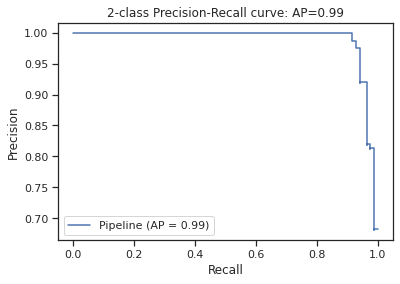

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(clf, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

# **Neural Network**
- I will train a neural network to predict Ad clicks based on the Advertising Dataset

In [ ]:
data.drop(columns=['Ad Topic Line', 'City', 'Timestamp', 'Age_bracket'], inplace=True)

In [ ]:
# Create training and validation set

val_dataframe = data.sample(frac=0.2, random_state=10)
train_dataframe = data.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 800 samples for training and 200 for validation


In [ ]:
# Function to extract labels, convert dataframe in Tensorflow Dataset and shuffle
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("Clicked on Ad")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

In [ ]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'Daily Time Spent on Site': <tf.Tensor: shape=(), dtype=float64, numpy=89.0>, 'Age': <tf.Tensor: shape=(), dtype=int64, numpy=37>, 'Area Income': <tf.Tensor: shape=(), dtype=float64, numpy=52079.18>, 'Daily Internet Usage': <tf.Tensor: shape=(), dtype=float64, numpy=222.26>, 'Male': <tf.Tensor: shape=(), dtype=string, numpy=b'1'>, 'Country': <tf.Tensor: shape=(), dtype=string, numpy=b'Cyprus'>, 'Time of Day': <tf.Tensor: shape=(), dtype=int64, numpy=15>, 'Day of Month': <tf.Tensor: shape=(), dtype=int64, numpy=26>, 'Day Name': <tf.Tensor: shape=(), dtype=string, numpy=b'Tuesday'>, 'Month of Year': <tf.Tensor: shape=(), dtype=string, numpy=b'January'>}
Target: tf.Tensor(0, shape=(), dtype=int64)


In [ ]:
# Batch the data for performance during training

train_ds = train_ds.batch(50)
val_ds = val_ds.batch(50)

In [ ]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature

def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

In [ ]:
# Convert columns into form we need
data['Male'] = data['Male'].astype('string')
data['Country'] = data['Country'].astype('string')
data['Day Name'] = data['Day Name'].astype('string')
data['Month of Year'] = data['Month of Year'].astype('string')

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from functools import partial

## **Compile Model**

In [ ]:
tf.keras.backend.clear_session() # Resets all keras states

tf.random.set_seed(45)

# Categorical features encoded as integers
time = keras.Input(shape=(1,), name="Time of Day", dtype="int64")
day_month = keras.Input(shape=(1,), name="Day of Month", dtype="int64")


# Categorical feature encoded as string
male = keras.Input(shape=(1,), name="Male", dtype="string")
country = keras.Input(shape=(1,), name="Country", dtype="string")
day_name = keras.Input(shape=(1,), name="Day Name", dtype="string")
month = keras.Input(shape=(1,), name="Month of Year", dtype="string")

# Numerical features
internet_usage = keras.Input(shape=(1,), name="Daily Internet Usage")
income = keras.Input(shape=(1,), name="Area Income")
time_on_site = keras.Input(shape=(1,), name="Daily Time Spent on Site")
age = keras.Input(shape=(1,), name="Age")


all_inputs = [
    time,
    day_month,
    male,
    country,
    day_name,
    month,
    internet_usage,
    income,
    time_on_site,
    age
]

# Integer categorical features
time_encoded = encode_categorical_feature(time, "Time of Day", train_ds, False)
day_month_encoded = encode_categorical_feature(day_month, "Day of Month", train_ds, False)


# String categorical features
male_encoded = encode_categorical_feature(male, "Male", train_ds, True)
country_encoded = encode_categorical_feature(country, "Country", train_ds, True)
day_name_encoded = encode_categorical_feature(day_name, "Day Name", train_ds, True)
month_encoded = encode_categorical_feature(month, "Month of Year", train_ds, True)

# Numerical features
internet_usage_encoded = encode_numerical_feature(internet_usage, "Daily Internet Usage", train_ds)
income_encoded = encode_numerical_feature(income, "Area Income", train_ds)
time_on_site_encoded = encode_numerical_feature(time_on_site, "Daily Time Spent on Site", train_ds)
age_encoded = encode_numerical_feature(age, "Age", train_ds)


all_features = layers.concatenate(
    [
        time_encoded,
        day_month_encoded,
        male_encoded,
        country_encoded,
        day_name_encoded,
        month_encoded,
        internet_usage_encoded,
        income_encoded,
        time_on_site_encoded,
        age_encoded
    ]
)


# Create thin wrapper for Dense layer
RegularizedDense = partial(keras.layers.Dense,
                           activation = "relu",
                           # Add regularization to improve generalization
                           kernel_regularizer = keras.regularizers.l2(0.03))

# Model Structure
x = RegularizedDense(64)(all_features)
x = RegularizedDense(32)(x)
x = RegularizedDense(16)(x)
x = layers.Dropout(0.50)(x) # Help prevent overfitting
output = layers.Dense(1, activation="sigmoid")(x)


# Compile Model
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

## **Plot Model Architecture**

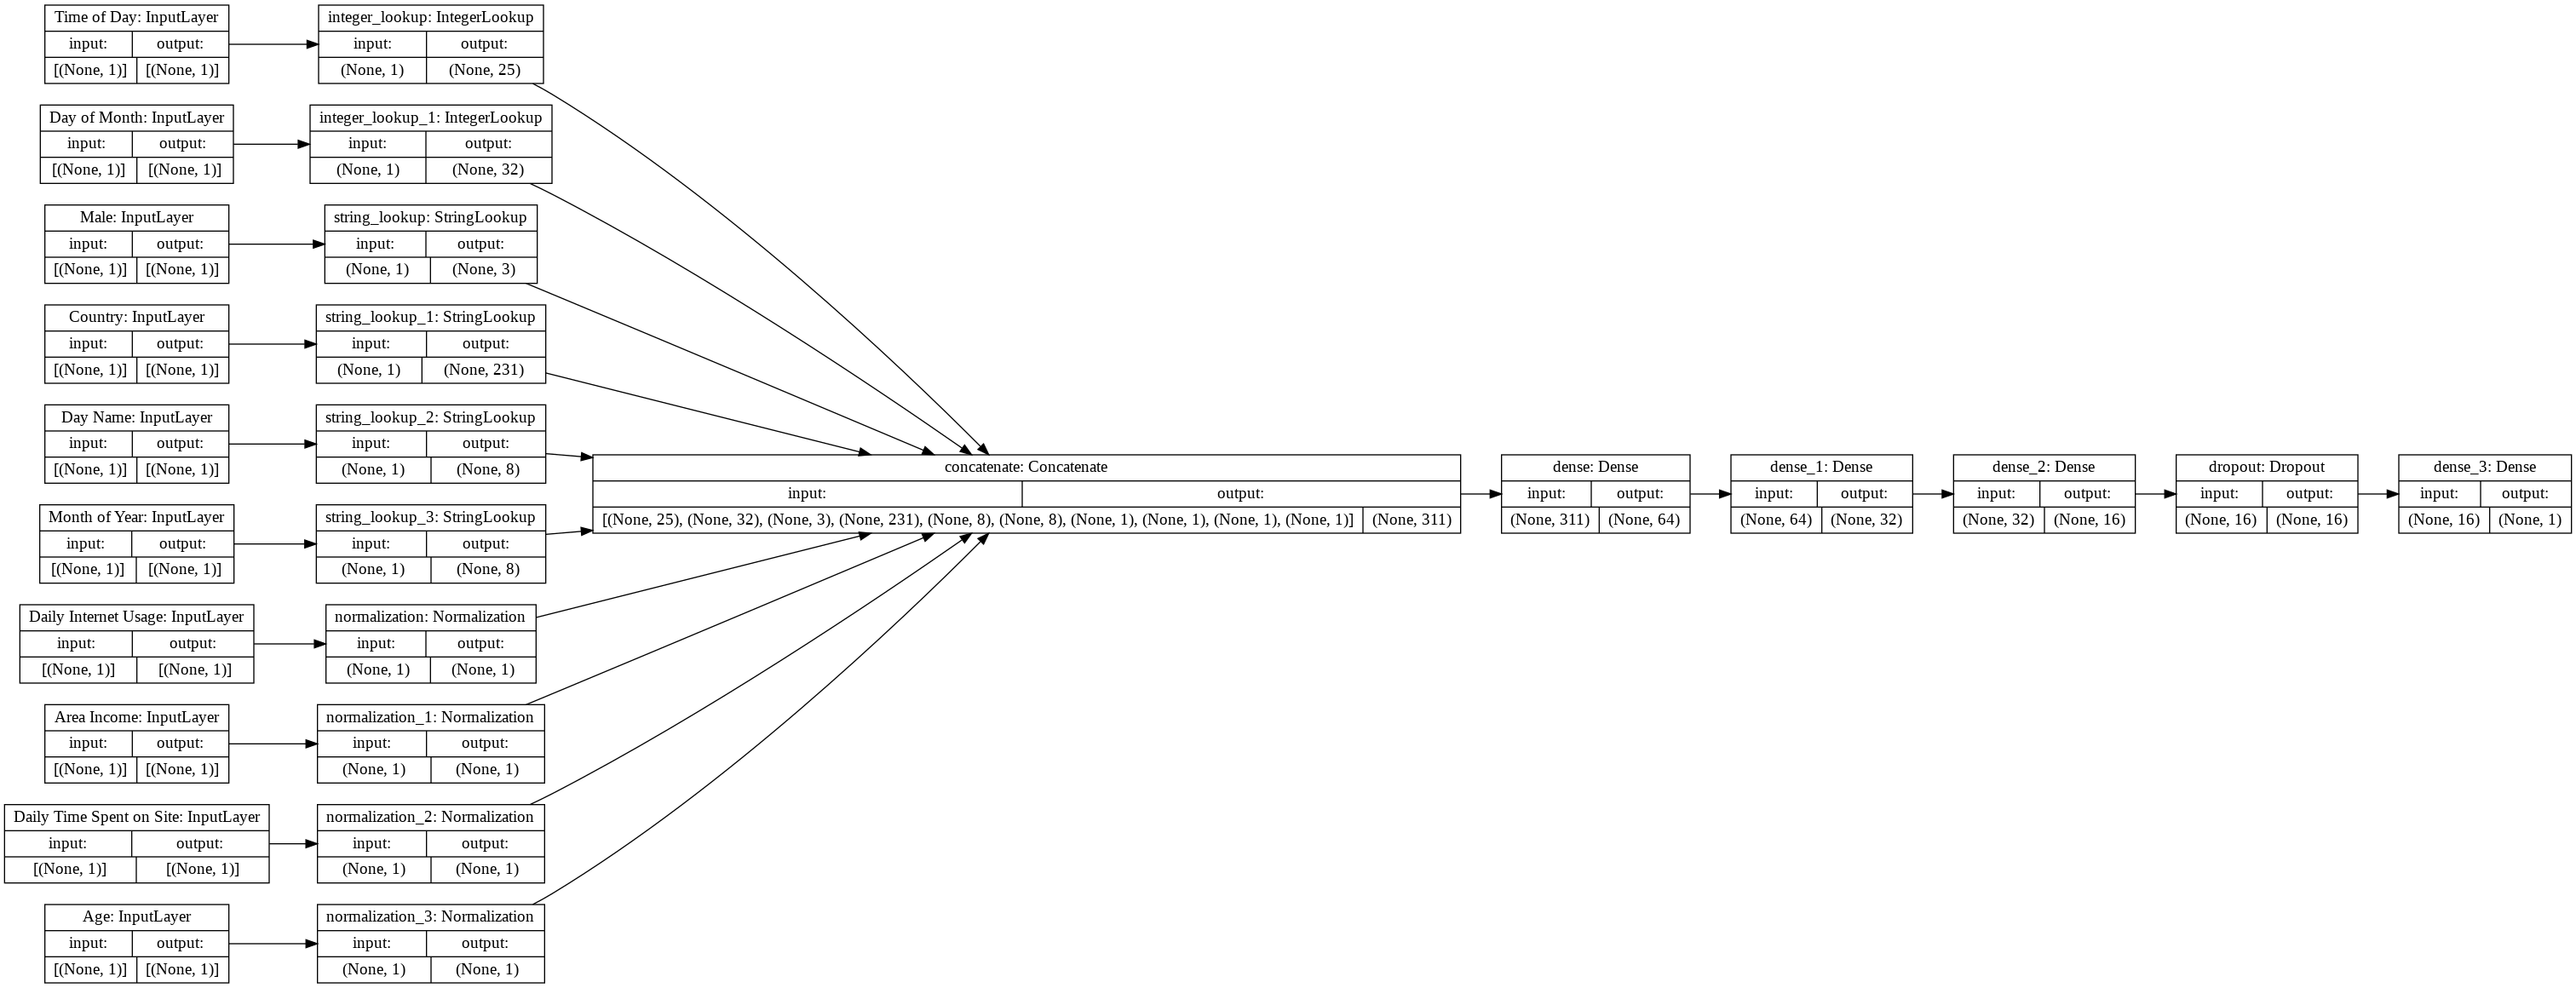

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

## **Train Model**

In [ ]:
# Early Stopping Callback
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=4,
                                            restore_best_weights=True)

# Callback to control learning rate
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.20,
                              patience=3, min_lr=0.001)

In [ ]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[reduce_lr, es_callback])

Epoch 1/50
16/16 [==============================] - 1s 24ms/step - loss: 5.1038 - accuracy: 0.5487 - val_loss: 4.4017 - val_accuracy: 0.5600
Epoch 2/50
16/16 [==============================] - 0s 4ms/step - loss: 3.8825 - accuracy: 0.6850 - val_loss: 3.3449 - val_accuracy: 0.7800
Epoch 3/50
16/16 [==============================] - 0s 4ms/step - loss: 2.9661 - accuracy: 0.8400 - val_loss: 2.5528 - val_accuracy: 0.9150
Epoch 4/50
16/16 [==============================] - 0s 5ms/step - loss: 2.2805 - accuracy: 0.9250 - val_loss: 1.9714 - val_accuracy: 0.9400
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 1.7814 - accuracy: 0.9475 - val_loss: 1.5532 - val_accuracy: 0.9350
Epoch 6/50
16/16 [==============================] - 0s 4ms/step - loss: 1.4209 - accuracy: 0.9575 - val_loss: 1.2484 - val_accuracy: 0.9500
Epoch 7/50
16/16 [==============================] - 0s 5ms/step - loss: 1.1498 - accuracy: 0.9625 - val_loss: 1.0200 - val_accuracy: 0.9550
Epoch 8/50
16/16 [=

## **Evaluate**

In [ ]:
model.evaluate(x = val_ds)

4/4 [==============================] - 0s 3ms/step - loss: 0.2706 - accuracy: 0.9500


[0.2705748677253723, 0.949999988079071]

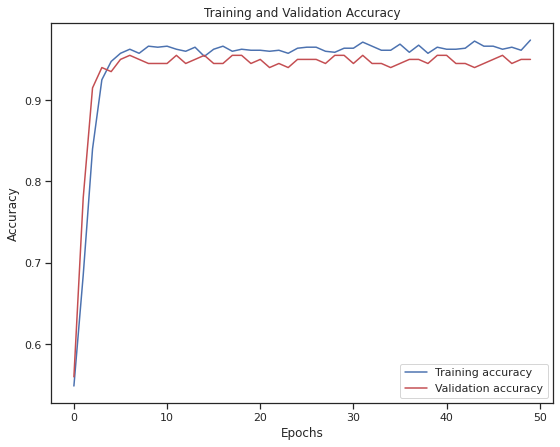

In [ ]:
def visualize_accuracy(history, title):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(accuracy))
    plt.figure(figsize=(9,7))
    plt.plot(epochs, accuracy, "b", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


visualize_accuracy(history, "Training and Validation Accuracy")

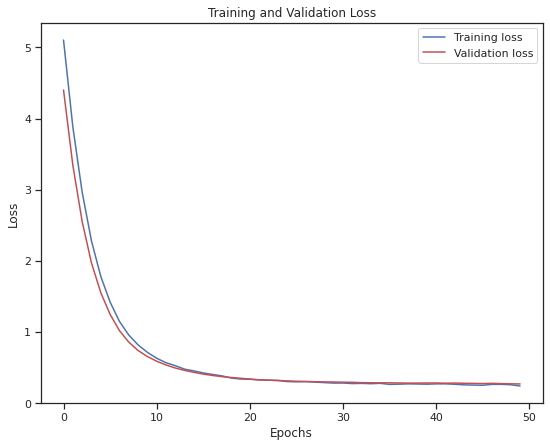

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure(figsize=(9,7))
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")